## Fundamentals of TensorFlow and learning algorithms
- [Tutorial Video](https://www.youtube.com/watch?v=tPYj3fFJGjk&t=1958s)
- [TensorFlow Introduction Module](https://colab.research.google.com/drive/1F_EWVKa8rbMXi3_fG0w7AtcscFq7Hi7B#forceEdit=true&sandboxMode=true&scrollTo=UU4MMhB_rxvz)
- [Learning Algorithms Module](https://colab.research.google.com/drive/15Cyy2H7nT40sGR7TBN5wBvgTd57mVKay#forceEdit=true&sandboxMode=true&scrollTo=qcII_xj9Ntyo)

### Install and import packages 

In [1]:
# pip install tensorflow
# pip install scikit-learn

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf  
from tensorflow.keras import layers, models
print(tf.version) # Should be >= 2


<module 'tensorflow._api.v2.version' from 'c:\\Users\\chris\\OneDrive\\Matthews South\\Matthews South Codebase\\wst-synch-up\\.venv\\Lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


### Creating variables in TensorFlow
- Tensor = vector
- Rank/degree = dimensions involved in a tensor
    - Rank0 = scalar
- Feature = input info
- Label = output info

Supervised learning:
    - Trained using already known features and labels (compares ai prediction to actual label)
    - Produces labels given a different set of features

In [2]:
rank1_tensor = tf.Variable(["Test", "something", "ok"], tf.string) # One dimensional vector
rank2_tensor = tf.Variable([["test", "ok"], ["test", "yes"], ["test", "yes"]], tf.string) # Two dimensional vector
rank3_tensor = tf.Variable([[[1], [2]], [[1], [2]], [[1], [2]]], tf.int32) # Two dimensional vector
print(tf.rank(rank2_tensor)) # Returns dimension of vector 
print(rank2_tensor.shape) # Returns shape of vector (#items in first dimension, #items in second dimension)
print(rank3_tensor.shape) # Returns shape of vector (#items in dimension1, #items in dimension2, #items in dimension3)

tf.Tensor(2, shape=(), dtype=int32)
(3, 2)
(3, 2, 1)


### Practice data about the Titanic

In [3]:
# Load Titanic deaths dataset - try to find linear pattern correlating to likelihood of death
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
print(y_train, '\n', y_eval)

clear_output()
dftrain.head() # Returns the first 5 entries of the dataframe

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


### Creating graphs to understand the data

<Axes: >

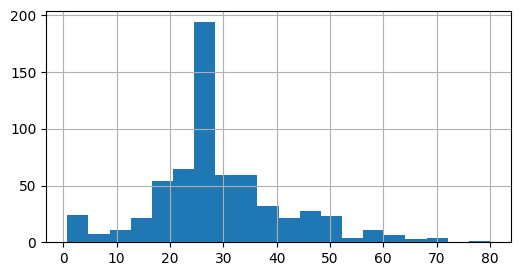

In [4]:
plt.figure(figsize=(6, 3))
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

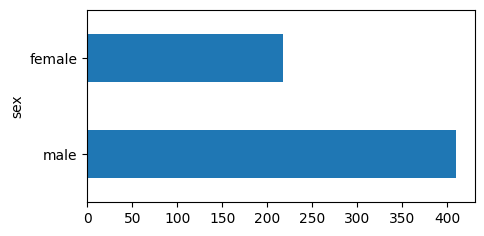

In [5]:
plt.figure(figsize=(5, 2.5))
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

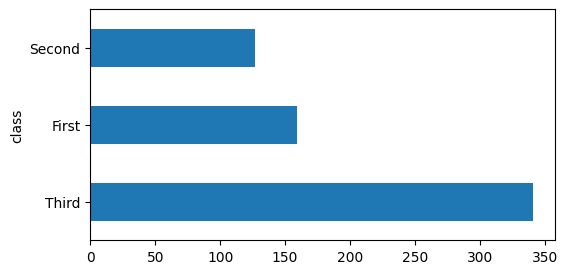

In [6]:
plt.figure(figsize=(6, 3))
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

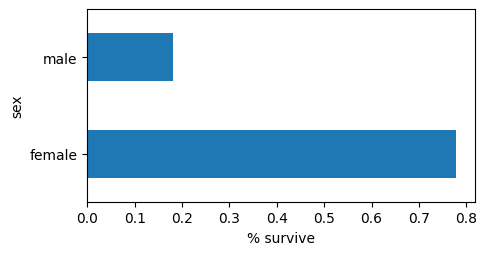

In [7]:
plt.figure(figsize=(5, 2.5))
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

### Creating a list of data categories to be fed into the model

In [8]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary) # creates categorical column
  indicator_column = tf.feature_column.indicator_column(categorical_column) # reformat into the parameter type of the model object constructor
  feature_columns.append(indicator_column) # adds column objects to the list:

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns, '\n\n Towns: ', dftrain['embark_town'].unique())

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_

### Create model, load data into model, evaluate model's accuracy
- Data is fed in batches (of size 32 in this case) to prevent massive datasets from bogging down RAM
- The number of epochs = the number of times the model sees the entire dataset
- The make_dataset function below defines how the data will be broken into epochs and batches
    - The model needs a `tf.data.Dataset` object as input
- **The video originally used a linear regression model, but I believe this uses a logistic regression**
    - I am not sure what the logic is behind using ReLU (Rectified Linear Unit) activation functions for the first two layers is but supposedly this is commonplace
    - In my understanding, this model takes on piece of data that goes to 128 nuerons in the first layer, which then create a map to the 128 nuerons in the second layer, which are interpreted by the sigmoid function into one probability value between 0 and 1

In [9]:
def make_dataset(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32): # returns tf.data.Dataset object
  ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
  if shuffle:
    ds = ds.shuffle(1000)  # randomize order of data
  ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
  return ds  # return the dataset

# feature data is dftrain (does not contain survival) and label data is y_train (survival)
train_dataset = make_dataset(dftrain, y_train) 
eval_dataset = make_dataset(dfeval, y_eval, num_epochs=1, shuffle=False)

# The following several lines don't work because TensorFlow recently replaced estimator with keras
# Create the model based on the data categories - It is an estimator that uses linear classification
# linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# linear_est.train(train_input_fn)  # trains the model - not completely sure how this works behind the scenes
# result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data
# print(result['accuracy'])
# print(result)

model = models.Sequential() # The keras sequential model allows for layers to be added sequentially
model.add(layers.DenseFeatures(feature_columns))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # This final layer converts the previous layers' output into probabilities

# The optimizer adjusts the model's learning process (trying to understand this gets pretty in depth)
# Binary cross-entropy is the conventional function to use for measuring the discrepancy between predicted probabilities and actual labels
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training statistics:\n")
model.fit(train_dataset, epochs=10) # Train the model
loss, accuracy = model.evaluate(eval_dataset) # Evaluate the model

clear_output()
print('\nAccuracy tested against evaluation dataset:', round(accuracy*100, 2), "%")


Accuracy tested against evaluation dataset: 79.92 %


### Predict chance of survival for a single person

In [10]:
predictions = list(model.predict(eval_dataset))
person = np.random.randint(0, len(dfeval))
clear_output()
print(dfeval.loc[person])
print(f"\nPredicted chance of survival: {round(predictions[person][0]*100, 2)}%")
survival = "yes" if y_eval[person] else "no"
print(f"Did they survive: {survival}")

sex                          male
age                          34.0
n_siblings_spouses              0
parch                           0
fare                         13.0
class                      Second
deck                            D
embark_town           Southampton
alone                           y
Name: 4, dtype: object

Predicted chance of survival: 5.56%
Did they survive: yes


### Other learning models
- Linear/logistic regression is likely the best choice for 
- Classification
    - Given data that belongs in groups (like ___ for example) produces a classification based on what group the model thinks a data element should be in 